In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Data Preparation**

In [0]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [74.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

In [0]:
# download cifar 100 dataset python version
!ls "drive/My Drive/Colab Notebooks/256 large scale analytic/cifar-100-python/train"

'drive/My Drive/Colab Notebooks/256 large scale analytic/cifar-100-python/train'


In [0]:
#unpickle the file
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic
# train data
datatrain = unpickle('drive/My Drive/Colab Notebooks/256 large scale analytic/cifar-100-python/train')
# test data
datatest = unpickle('drive/My Drive/Colab Notebooks/256 large scale analytic/cifar-100-python/test')
# meta data
datameta = unpickle("drive/My Drive/Colab Notebooks/256 large scale analytic/cifar-100-python/meta")

#convert the data type from byte to utf-8
fine_labels = [x.decode('utf-8') for x in datameta.get(b'fine_label_names')]
print(fine_labels)
coarse_labels = [x.decode('utf-8')for x in datameta.get(b'coarse_label_names')]
print(coarse_labels)
#fine_labels = [x for x in datatrain.get(b'fine_labels')]
#type(fine_labels[0])


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

int

In [0]:
# get the index of target superclasses(samll_mammals and medium_mammals) 
medium_mammals_index = [coarse_labels.index(x) for x in coarse_labels if x == 'medium_mammals']
small_mammals_index = [coarse_labels.index(x) for x in coarse_labels if x == 'small_mammals']
print("medium_mammals_index:", medium_mammals_index)
print("small_mammals_index:", small_mammals_index )

medium_mammals_index: [12]
small_mammals_index: [16]


In [0]:
import findspark
findspark.init(os.environ["SPARK_HOME"])# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [0]:
from pyspark import SparkContext
 sc = spark.sparkContext
# generate the train data RDD
cifar_RDD_train = sc.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatrain.get(b'filenames')],\
    datatrain.get(b'fine_labels'), datatrain.get(b'coarse_labels'), \
    datatrain.get(b'data'))))
cifar_RDD_train.count()


50000

In [0]:
cifar_RDD_train.map(lambda x: x[3]).take(1)

[array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)]

In [0]:
# generate the test data RDD
cifar_RDD_test = sc.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatest.get(b'filenames')],\
    datatest.get(b'fine_labels'), datatest.get(b'coarse_labels'), \
    datatest.get(b'data'))))
cifar_RDD_test.count()


10000

# **Combine the training RDD and test RDD into one RDD**

In [0]:
# combine the train RDD and test RDD into one RDD
combine_rdd = cifar_RDD_train.union(cifar_RDD_test)
combine_rdd.count()

60000

In [0]:
combine_rdd.take(2)

[('bos_taurus_s_000507.png',
  19,
  11,
  array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)),
 ('stegosaurus_s_000125.png',
  29,
  15,
  array([255, 253, 253, ..., 253, 253, 255], dtype=uint8))]

In [0]:
from pyspark.sql.types import Row
from pyspark.mllib.linalg import DenseVector

# convert the RDD into spark dataframe
# MLlib recognizes the following types as dense vectors: NumPy’s array and Python’s list, e.g., [1, 2, 3]
combine_df = spark.createDataFrame( combine_rdd.map(lambda x: Row(filenames=x[0], fine_labels=x[1], coarse_labels=x[2], data=DenseVector(x[3]))) )


60000

In [0]:
combine_df.show()

+-------------+--------------------+--------------------+-----------+
|coarse_labels|                data|           filenames|fine_labels|
+-------------+--------------------+--------------------+-----------+
|           11|[255.0,255.0,255....|bos_taurus_s_0005...|         19|
|           15|[255.0,253.0,253....|stegosaurus_s_000...|         29|
|            4|[250.0,248.0,247....|mcintosh_s_000643...|          0|
|           14|[124.0,131.0,135....|altar_boy_s_00143...|         11|
|            1|[43.0,32.0,87.0,1...|cichlid_s_000031.png|          1|
|            5|[190.0,191.0,194....|  phone_s_002161.png|         86|
|           18|[50.0,56.0,52.0,5...|car_train_s_00004...|         90|
|            3|[178.0,175.0,175....| beaker_s_000604.png|         28|
|           10|[122.0,127.0,134....|    fog_s_000397.png|         23|
|           11|[255.0,255.0,255....|rogue_elephant_s_...|         31|
|            5|[83.0,67.0,61.0,5...|computer_keyboard...|         39|
|           17|[254.

# **Filter out the assigned superclasses**

In [0]:
# get the index of ten classes of animals
medium_sized_mammals_index = [ fine_labels.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_index = [ fine_labels.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

target_index = medium_sized_mammals_index + small_mammals_index
print (medium_sized_mammals_index, small_mammals_index)
print(target_index)


[34, 63, 64, 66, 75] [36, 50, 65, 74, 80]
[34, 63, 64, 66, 75, 36, 50, 65, 74, 80]


In [0]:
from pyspark.sql.functions import col
#filter out the assigned ten fine classes
target_df = combine_df.filter(col('fine_labels').isin(target_index))
target_df.count()


6000

In [0]:
target_df.show()

+-------------+--------------------+--------------------+-----------+
|coarse_labels|                data|           filenames|fine_labels|
+-------------+--------------------+--------------------+-----------+
|           16|[71.0,46.0,74.0,8...|squirrel_s_002467...|         80|
|           16|[156.0,151.0,158....|  shrew_s_002233.png|         74|
|           12|[245.0,233.0,222....|opossum_s_001237.png|         64|
|           12|[255.0,255.0,255....| possum_s_002195.png|         64|
|           16|[30.0,21.0,30.0,3...|  lapin_s_000916.png|         65|
|           16|[60.0,60.0,95.0,1...|syrian_hamster_s_...|         36|
|           16|[69.0,75.0,80.0,6...|mus_musculus_s_00...|         50|
|           16|[36.0,36.0,38.0,4...|hamster_s_001554.png|         36|
|           12|[1.0,1.0,2.0,3.0,...| possum_s_000413.png|         64|
|           12|[58.0,98.0,105.0,...|  skunk_s_000825.png|         75|
|           12|[205.0,193.0,181....|raccoon_s_002740.png|         66|
|           12|[112.

# **visualize and validate the data**

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import VectorUDT

# add two columns fine label as fine and corase label as corase, and add the normalized data column, remove the original data column
# udf is user defined function, UDT is the user defined type for vector
target_name_df = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label], StringType())(target_df['coarse_labels'])) \
    .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], StringType())(target_df['fine_labels'])) \
    .withColumn("ndata", udf(lambda data: data/255.0, VectorUDT())(target_df['data'])) \
    .drop('data')
    

In [0]:
target_name_df.show()

+-------------+--------------------+-----------+--------------+---------+--------------------+
|coarse_labels|           filenames|fine_labels|        coarse|     fine|               ndata|
+-------------+--------------------+-----------+--------------+---------+--------------------+
|           16|squirrel_s_002467...|         80| small_mammals| squirrel|[0.27843137254901...|
|           16|  shrew_s_002233.png|         74| small_mammals|    shrew|[0.61176470588235...|
|           12|opossum_s_001237.png|         64|medium_mammals|   possum|[0.96078431372549...|
|           12| possum_s_002195.png|         64|medium_mammals|   possum|[1.0,1.0,1.0,1.0,...|
|           16|  lapin_s_000916.png|         65| small_mammals|   rabbit|[0.11764705882352...|
|           16|syrian_hamster_s_...|         36| small_mammals|  hamster|[0.23529411764705...|
|           16|mus_musculus_s_00...|         50| small_mammals|    mouse|[0.27058823529411...|
|           16|hamster_s_001554.png|         36| s

In [0]:
# generate sample data randomly
fractions = dict()
for fine in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']:
  fractions[fine] = 0.04      #24pictures for each class

sample_df = target_name_df.sampleBy('fine', fractions)
sample_df.count()

256

In [0]:
#type(sample_df)

pyspark.sql.dataframe.DataFrame

In [0]:
# generate the sample list in order to use later
samples = sample_df.select('coarse', 'fine', 'ndata').orderBy('coarse', 'fine').rdd.collect()

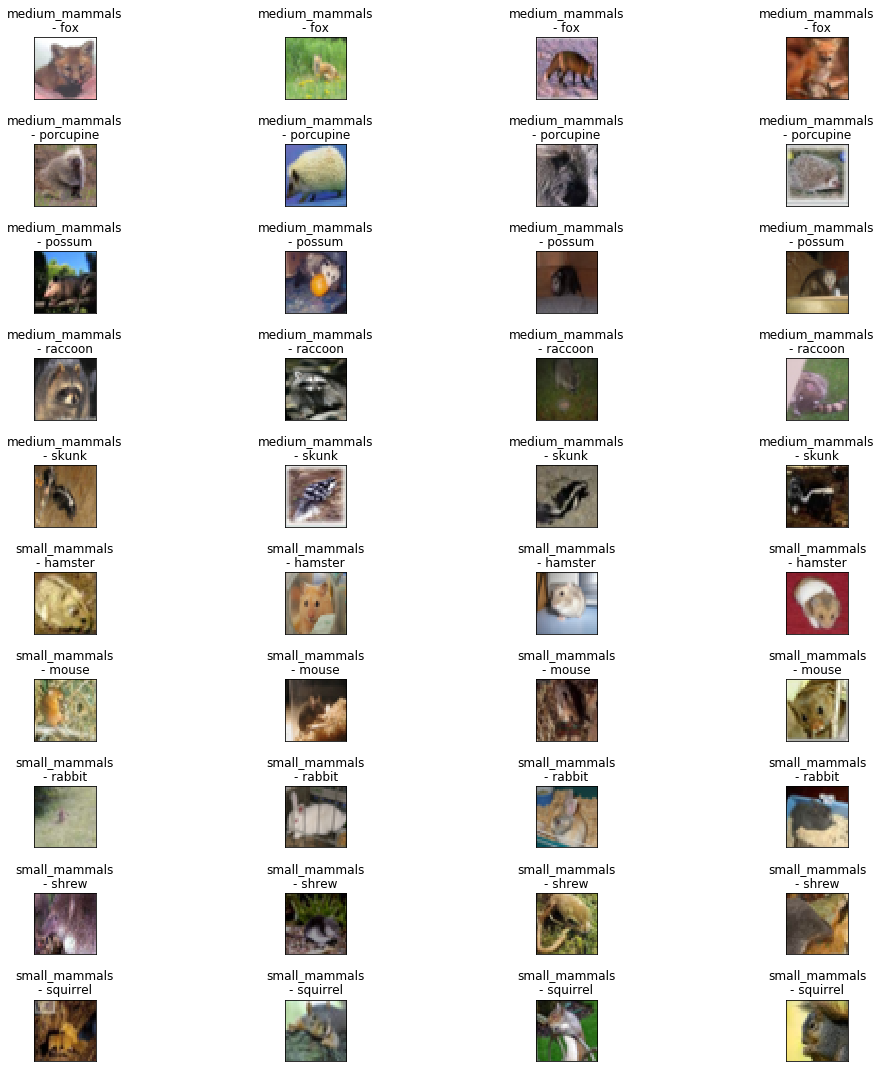

In [0]:
# initialize the dict, the key is the ten fine class, the count is 0 
counts = dict.fromkeys(['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'], 0) 

import matplotlib.pyplot as plt
#import math

fig = plt.figure(figsize=(15, 15))

index = 0
for sample in samples:
  counts[sample.fine] += 1
  if counts[sample.fine] > 4:
    continue
  
  #print(type(sample.ndata))
  img = sample.ndata.reshape(3,32,32).transpose([1, 2, 0])
  fig.add_subplot(10, 4, index+1, xticks=[], yticks=[])
  plt.imshow(img)
  plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  index += 1
      
fig.set_tight_layout(True)

In [0]:
from pyspark.ml.feature import StringIndexer

In [0]:
# Change the coarse label of training set into a binary label
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='binary_index')
target_name_df = stringindexer.fit(target_name_df).transform(target_name_df)
target_name_df.select('binary_index').distinct().collect()
